# dataloader test runs

## Images

In [20]:
import pandas as pd
import glob

file_list = glob.glob("/home/rc/version-cv/data/googleresearch/mathwriting/data/*train*.parquet")

if not file_list:
    raise FileNotFoundError("No parquet files found!")

df_list = [pd.read_parquet(f) for f in file_list]
df = pd.concat(df_list, ignore_index=True)

print(df.head())

                                               image  \
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   

                                               latex         sample_id  \
0                  (\begin{matrix}p\\ k\end{matrix})  8b7e03d7a0718f6c   
1               \frac{\frac{1}{176}}{\frac{469}{10}}  a9bcb7658c333bcf   
2  n_{rel}=\frac{n_{0}}{\sqrt{8\cdot\frac{v^{9}}{...  07c4d09473770d39   
3                                     \prod expxf(x)  0ccdf3b3965e14dd   
4                                      \overline{A}D  ff1b6cbcb064c602   

  split_tag data_type  
0     train     human  
1     train     human  
2     train     human  
3     train     human  
4     train     human  


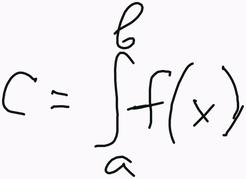

In [31]:
from IPython.display import display
from PIL import Image
import io

image_bytes = df.loc[6, "image"]["bytes"]
image = Image.open(io.BytesIO(image_bytes))

display(image)

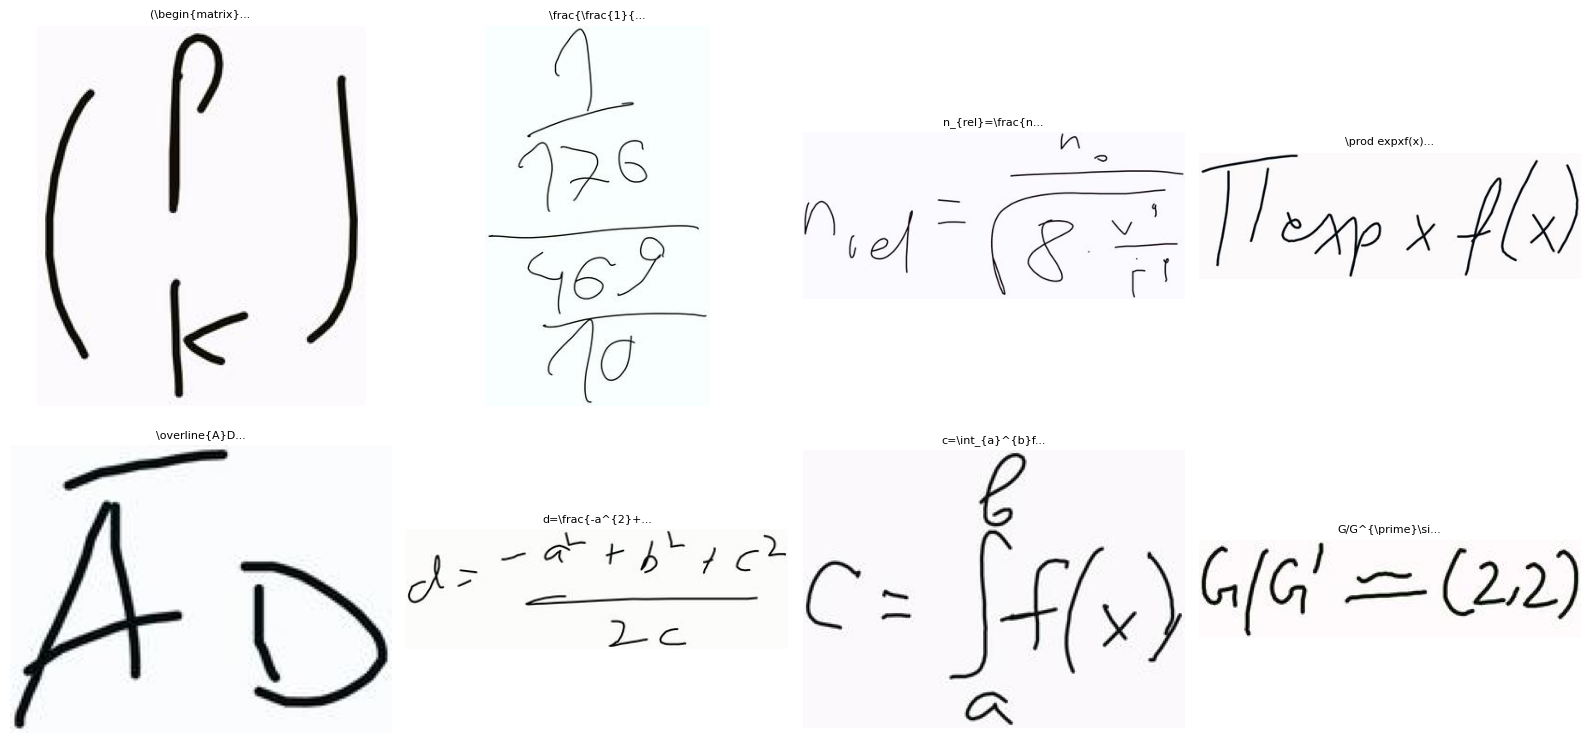

In [24]:
import matplotlib.pyplot as plt

num_samples = 8  # Number of images to show

plt.figure(figsize=(16, 8))
for i in range(num_samples):
    img_bytes = df.loc[i, "image"]["bytes"]
    img = Image.open(io.BytesIO(img_bytes))

    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
    ax.set_title(df.loc[i, "latex"][:15] + "...", fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image
import io

shapes = []
modes = []

for idx, row in df.iterrows(100000):
    img_bytes = row["image"]["bytes"]
    img = Image.open(io.BytesIO(img_bytes))
    shapes.append(img.size)
    modes.append(img.mode)
    
print("Unique shapes:", set(shapes))
print("Unique modes:", set(modes))

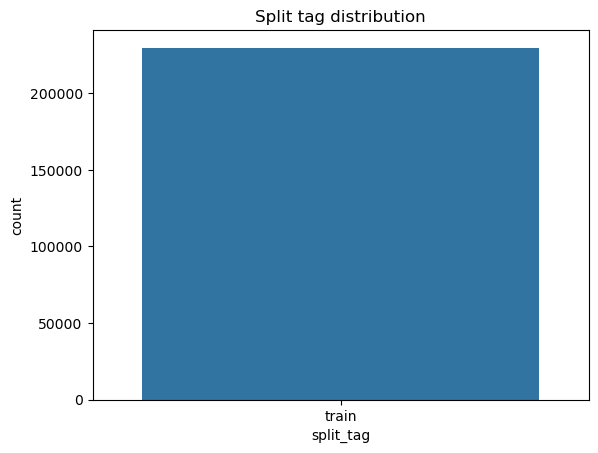

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df["split_tag"])
plt.title("Split tag distribution")
plt.show()

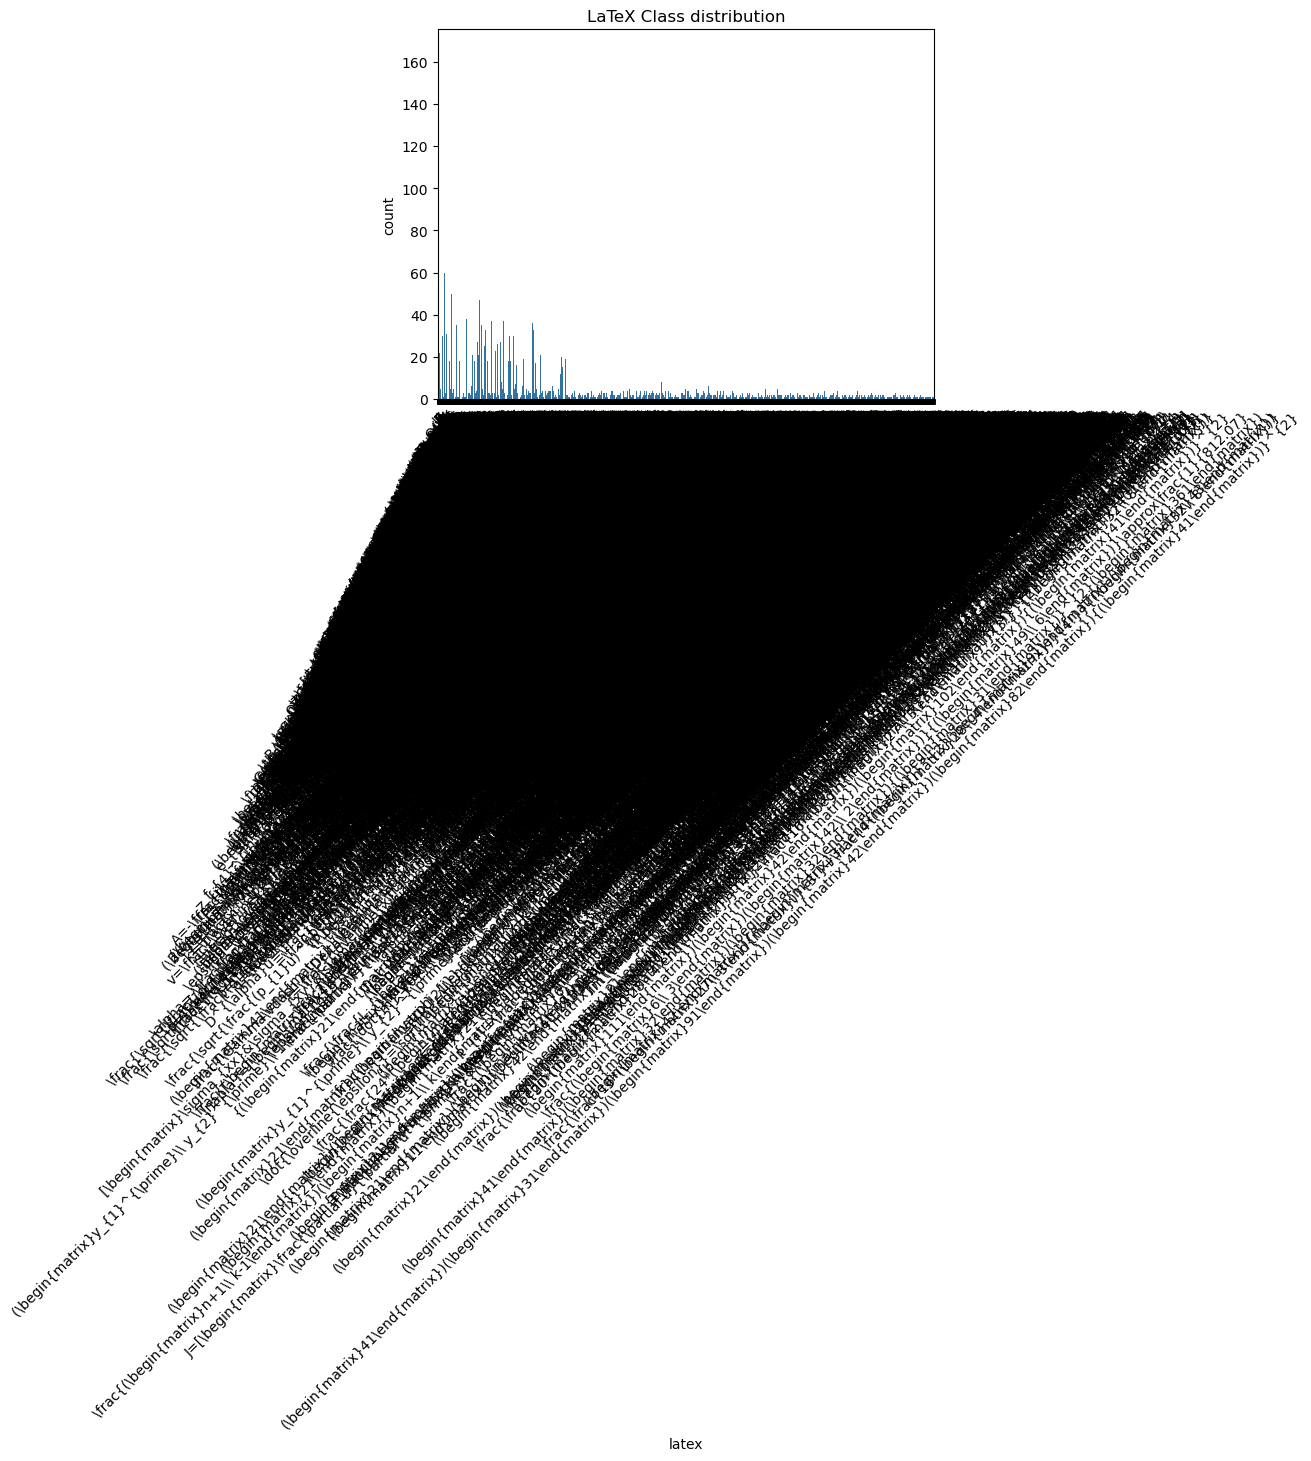

In [34]:
sns.countplot(x=df["latex"])
plt.title("LaTeX Class distribution")
plt.xticks(rotation=45)
plt.show()

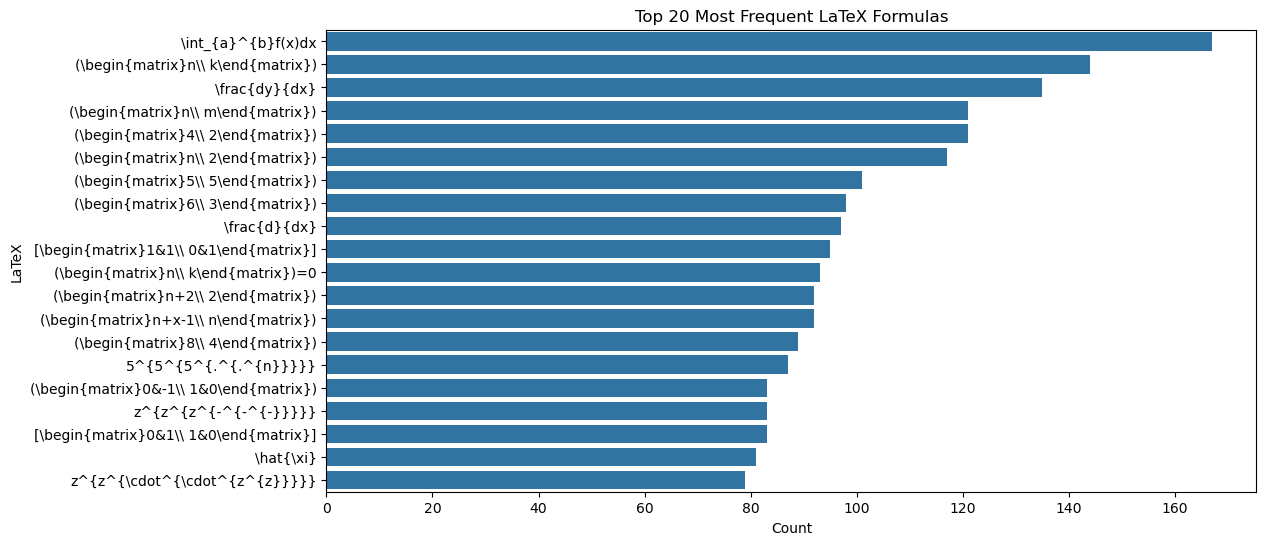

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 20
latex_counts = df["latex"].value_counts().nlargest(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=latex_counts.values, y=latex_counts.index)
plt.title(f"Top {top_n} Most Frequent LaTeX Formulas")
plt.xlabel("Count")
plt.ylabel("LaTeX")
plt.show()

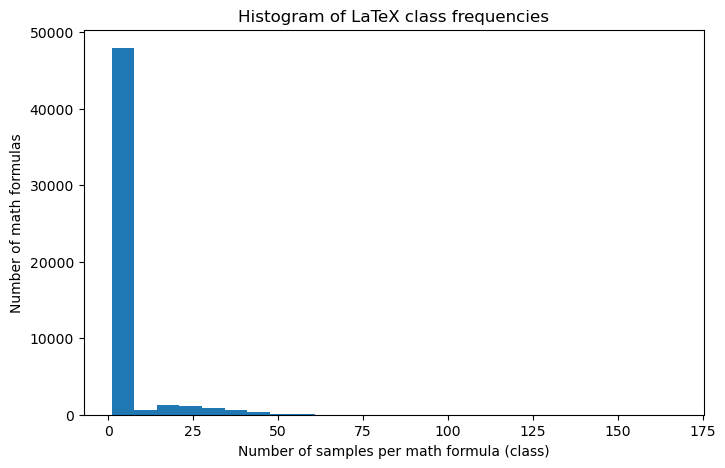

In [68]:
latex_freqs = df["latex"].value_counts()

plt.figure(figsize=(8, 5))
plt.hist(latex_freqs.values, bins=25)
plt.title("Histogram of LaTeX class frequencies")
plt.xlabel("Number of samples per math formula (class)")
plt.ylabel("Number of math formulas")
plt.show()

In [70]:
print("Number of unique LaTeX math formulas:", df["latex"].nunique())
print("Mean samples per math formula:", latex_freqs.mean())
print("Median samples per math formula:", latex_freqs.median())
print("Max samples for any mathematical formula:", latex_freqs.max())
print("Min samples for any mathematical formula:", latex_freqs.min())

Number of unique LaTeX math formulas: 52995
Mean samples per math formula: 4.337465798660251
Median samples per math formula: 2.0
Max samples for any mathematical formula: 167
Min samples for any mathematical formula: 1


In [71]:
rare_formulas = latex_freqs[latex_freqs < 5]
print("Number of math formulas with < 5 samples:", rare_formulas.count())

Number of math formulas with < 5 samples: 45407


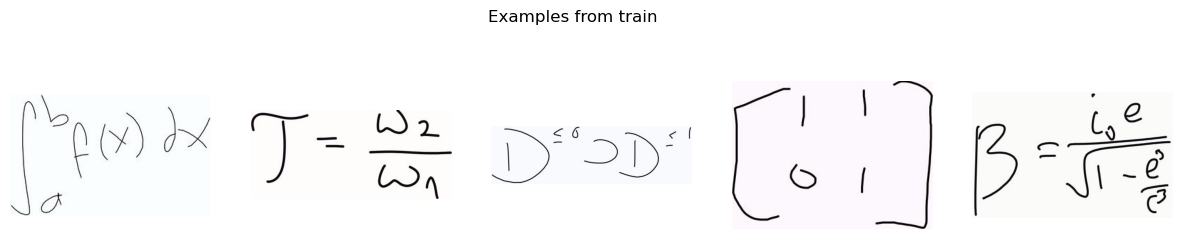

In [35]:
import matplotlib.pyplot as plt
import random

classes = df["split_tag"].unique()  # or use your actual class column

for cls in classes:
    sample_df = df[df["split_tag"] == cls]
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f"Examples from {cls}")

    for ax in axes:
        row = sample_df.sample(1).iloc[0]
        img_bytes = row["image"]["bytes"]
        img = Image.open(io.BytesIO(img_bytes))
        ax.imshow(img)
        ax.axis("off")

    plt.show()

In [36]:
broken = []

for idx, row in df.iterrows():
    try:
        img_bytes = row["image"]["bytes"]
        Image.open(io.BytesIO(img_bytes)).verify()
    except Exception:
        broken.append(idx)

print(f"Number of corrupted images: {len(broken)}")

Number of corrupted images: 0


In [37]:
import numpy as np

pixels = []

for idx, row in df.sample(100).iterrows():  # sample for speed
    img_bytes = row["image"]["bytes"]
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    arr = np.array(img)
    pixels.append(arr)

# Check combined range
all_pixels = np.concatenate([arr.flatten() for arr in pixels])
print("Min pixel value:", np.min(all_pixels))
print("Max pixel value:", np.max(all_pixels))

Min pixel value: 0
Max pixel value: 255


In [38]:
means = []
stds = []

for idx, row in df.sample(100).iterrows():
    img_bytes = row["image"]["bytes"]
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    arr = np.array(img) / 255.0
    means.append(arr.mean(axis=(0, 1)))
    stds.append(arr.std(axis=(0, 1)))

print("Mean per channel:", np.mean(means, axis=0))
print("Std per channel:", np.mean(stds, axis=0))

Mean per channel: [0.93478909 0.93507107 0.93477262]
Std per channel: [0.18477411 0.18478893 0.18467576]


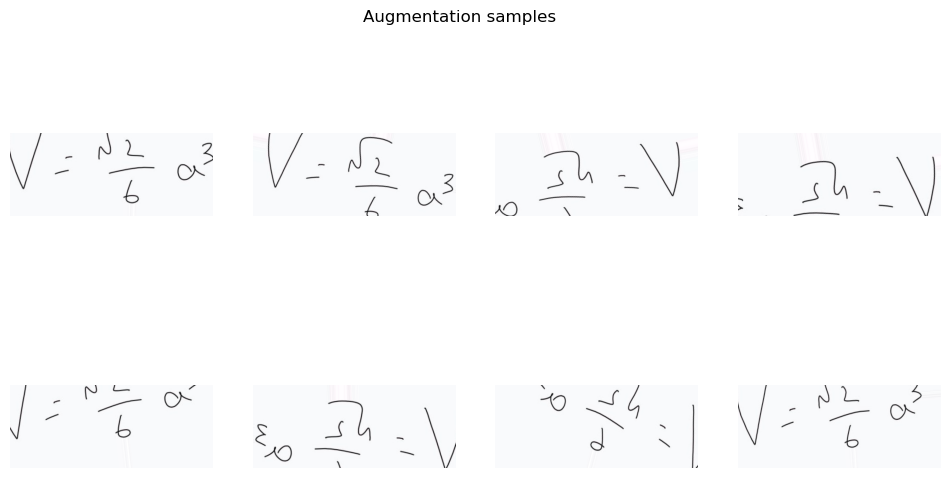

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Check a single math problem sample
row = df.sample(13).iloc[0]
img_bytes = row["image"]["bytes"]
img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
arr = np.expand_dims(np.array(img), 0)

aug_iter = datagen.flow(arr, batch_size=1)

plt.figure(figsize=(12, 6))
for i in range(8):
    batch = next(aug_iter)
    plt.subplot(2, 4, i + 1)
    plt.imshow(batch[0])
    plt.axis("off")
plt.suptitle("Augmentation samples")
plt.show()

In [ ]:
# Image pipeline for computer vision looks good. May not be robust/production grade for all dataset formats (.xlsx, .csv, .txt, etc)
# But looks promising. Test runs on prototype and final tabular + NLP + CV TBD. 